# Glühlampenspektrum

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from matplotlib.gridspec import GridSpec
import scipy.constants as c

In [7]:
class Glueh:
    def __init__(self,path,norm=False):
        data = np.loadtxt(path).T
        if norm:
            norm_factor = trapezoid(data[1],data[0])
            self.steps = np.array(data[0])
            self.intensity = np.array(data[1])/norm_factor
            print(norm_factor)
        else:
            self.steps = np.array(data[0])
            self.intensity = np.array(data[1])

    def steps_to_lambda(self,steps,p):
        return p[0]*steps**2+p[1]*steps+p[2]

    def planck(self,lam,T):
        '''Planck in Wellenlängendarstellung. Dran denken, dass nm in Meter umgerechnet werden müssen.'''
        return 8*c.pi*c.h*c.c/lam**5/(np.exp(c.h*c.c/lam/c.k/T)-1)

        
        
class spek:        
    def __init__(self,path):
        self.path=path
        data=np.loadtxt(path)
        self.steps=[]
        self.intensity=[]
        self.ru_lines=[495.31,496.39,498.34,501.61,502.30,506.40,507.2,507.66,508.94,513.39,515.15,517.11,519.67,523.54,526.15,532.38,536.41,539.21,543.31,558.03,564.93,565.53,572.57,589.16,589.75,620.8,630.01,607.24,616.13]
        for line in data:
            self.steps.append(line[0])
            self.intensity.append(line[1])
        self.steps,self.intensity=np.array(self.steps),np.array(self.intensity)
        self.peaks_index=self.peaks()
        self.parameter, self.parameter_err,self.steps_cali,self.steps_cali_err=self.cali()
        print(self.parameter, self.parameter_err)

    def peaks(self):
        peaks_arr=find_peaks(self.intensity,height=0.01)[0]
        if self.path=="data/ru_spektrum.dat":
            peaks_arr=np.delete(peaks_arr,[0,1,2,14])
            peaks_arr=np.append(peaks_arr,[3664,3796])
        return peaks_arr

    def cali(self):
        p,pcov=np.polyfit(self.steps[self.peaks_index],self.ru_lines,2,cov=True)
        perr=np.sqrt(np.diag(pcov))
        steps_cali=p[0]*self.steps**2+p[1]*self.steps+p[2]
        steps_cali_err=perr[0]*self.steps**2+perr[1]*self.steps+perr[2]
        return p,perr,steps_cali,steps_cali_err

    def plot_spectrum(self):
        fig = plt.figure(figsize=(11, 6))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        fig1.set_title("Rubidium Spektrum gemessen mit dem Prismenspektrometer")
        fig1.set_ylabel("Intensity in a.u.")
        fig1.set_xlabel("pmt Position")
        fig1.set_xlim(10000,40000)
        fig1.plot(self.steps,self.intensity,label=f"Gemessenes Ru-Spektrum")
        fig1.plot(self.steps[self.peaks_index],self.intensity[np.array(self.peaks_index)],"o",label="Identifizierte Peaks")
        plt.tight_layout()
        plt.legend()
        plt.savefig("plots/Ru_spectrum1.pdf")
        plt.show()

    def plot_cali(self):
        fig = plt.figure(figsize=(11, 6))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        fig1.set_title("Kalibration des Prismenspektrometers mittels eines Rubidium Spektrums")
        fig1.set_ylabel("$\lambda_{Ru}$ in nm")
        fig1.set_xlabel("pmt Position")
        fig1.set_xlim(10000,40000)
        fig1.scatter(self.steps[self.peaks_index],self.ru_lines,c="C0",label="Gemessene Peaks")
        fig1.plot(self.steps,self.steps_cali,c="C0",label="Fit")
        fig1.plot(self.steps,self.steps_cali-self.steps_cali_err,c="C0",ls="--",label="Fehlerschlauch zum Fit")
        fig1.plot(self.steps,self.steps_cali+self.steps_cali_err,c="C0",ls="--")
        plt.tight_layout()
        plt.legend()
        plt.savefig("plots/Ru_cali1.pdf")
        plt.show()

In [8]:
file="ru_spektrum.dat"
spek1=spek(f"data/{file}")
# spek1.plot_cali()
p = spek1.parameter    # Parameter für Umrechnung in Wellenlänge

[7.05835870e-08 1.01924329e-03 4.75424576e+02] [1.6924379e-09 8.6105632e-05 9.8094030e-01]


Spektrum mit Linse ist sehr hässlich, weshalb es nicht ausgewertet wird. Normierung auf Maximum der höchsten Kurve. In diesem Fall also die theoretische Kurve  
nach Planck. Normiere experimentelle Daten auf Max. von 5.12 A und Planck auf eigenes Maximum.

C:\Users\ebel1\AppData\Local\Temp\ipykernel_22124\2842941292.py:18: RuntimeWarning: overflow encountered in exp
  return 8*c.pi*c.h*c.c/lam**5/(np.exp(c.h*c.c/lam/c.k/T)-1)


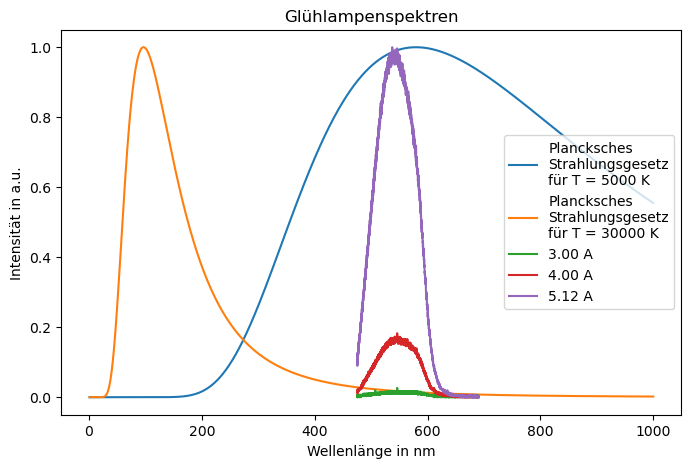

In [9]:
True_or_False = False
linse0 = Glueh('data/Gluehlampenspektrum/spek_linse_0.dat',norm=True_or_False)
spek300 = Glueh('data/Gluehlampenspektrum/spek_-3_300.dat',norm=True_or_False)
spek400 = Glueh('data/Gluehlampenspektrum/spek_-3_400.dat',norm=True_or_False)
spek512 = Glueh('data/Gluehlampenspektrum/spek_-3_512.dat',norm=True_or_False)
spek512_4 = Glueh('data/Gluehlampenspektrum/spek_-4_512.dat',norm=True_or_False)


fig = plt.figure(figsize=(8,5))

Temp = 5000
lam = np.linspace(1e-9,1000e-9,1000)
int_lam = spek512.planck(lam,Temp)
norm_factor_planck = max(int_lam)
plt.plot(lam*1e9,int_lam/norm_factor_planck,label=f'Plancksches\nStrahlungsgesetz\nfür T = {Temp} K')

Temp = 30000
lam = np.linspace(1e-9,1000e-9,1000)
int_lam = spek512.planck(lam,Temp)
norm_factor_planck = max(int_lam)
plt.plot(lam*1e9,int_lam/norm_factor_planck,label=f'Plancksches\nStrahlungsgesetz\nfür T = {Temp} K')

norm_factor = max(spek512.intensity)

plt.plot(spek300.steps_to_lambda(spek300.steps,p),spek300.intensity/norm_factor,label='3.00 A')
plt.plot(spek400.steps_to_lambda(spek400.steps,p),spek400.intensity/norm_factor,label='4.00 A')
plt.plot(spek512.steps_to_lambda(spek512.steps,p),spek512.intensity/norm_factor,label='5.12 A')
# plt.plot(spek512_4.steps_to_lambda(spek512_4.steps,p),spek512_4.intensity/norm_factor)
# plt.plot(linse0.steps_to_lambda(linse0.steps,p),linse0.intensity/norm_factor)


plt.legend(loc=5)
plt.xlabel('Wellenlänge in nm')
plt.ylabel('Intensität in a.u.')
plt.title('Glühlampenspektren')

plt.savefig('plots/gluehlampenspektren.pdf')

C:\Users\ebel1\AppData\Local\Temp\ipykernel_22124\2842941292.py:18: RuntimeWarning: overflow encountered in exp
  return 8*c.pi*c.h*c.c/lam**5/(np.exp(c.h*c.c/lam/c.k/T)-1)


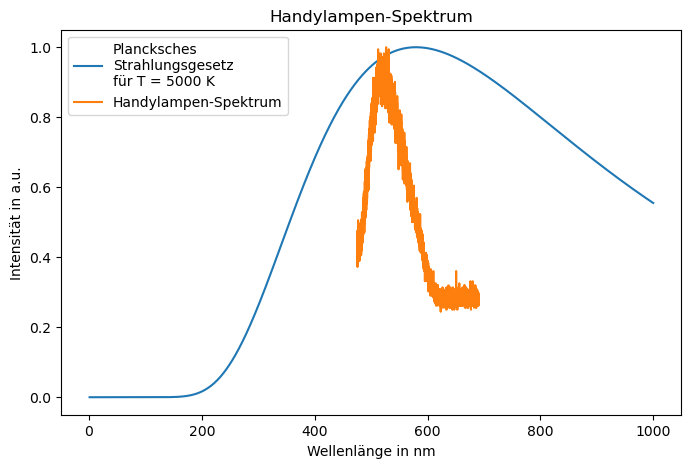

In [10]:
handy = Glueh('data/handy_spektrum_-4_ohnelinse.dat')

fig = plt.figure(figsize=(8,5))


Temp = 5000
lam = np.linspace(1e-9,1000e-9,1000)
int_lam = spek512.planck(lam,Temp)
norm_factor_planck = max(int_lam)
plt.plot(lam*1e9,int_lam/norm_factor_planck,label=f'Plancksches\nStrahlungsgesetz\nfür T = {Temp} K')

plt.plot(handy.steps_to_lambda(handy.steps,p),handy.intensity/max(handy.intensity),label='Handylampen-Spektrum')

plt.legend()
plt.xlabel('Wellenlänge in nm')
plt.ylabel('Intensität in a.u.')
plt.title('Handylampen-Spektrum')

plt.savefig('plots/handylampenspektrum.pdf')